# Sentiment Prediction on Yelp Data

## Library Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import copy
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nltk
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import operator
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score, confusion_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
import spacy
from keras.models import Sequential
from keras import layers
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from sklearn.cluster import KMeans
from keras.preprocessing.sequence import pad_sequences

In [2]:
## Loading the dataframe
file_business = pd.read_json('./Data/yelp_academic_dataset_business.json', lines = True)
file_review = pd.read_json('./Data/yelp_academic_dataset_review.json', lines = True)

print("Shape of the Business file :", file_business.shape)
print("Shape of the Review file :", file_review.shape)

Shape of the Business file : (209393, 14)
Shape of the Review file : (8021122, 9)


In [3]:
file_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None


In [5]:
file_review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52


## Data Preprocessing

#### 1. Selecting the reviews from the "Restaurant" business

In [6]:
## Function of selecting the reviews of "Restaurant Business" 
## This function can be used to extract the data of any business from the yelp dataset

def restau_reviews(a,b):
    rest_data =  a[a['categories'].str.contains('Restaurant') == True]
    review_rest = b[b.business_id.isin(rest_data['business_id']) == True]
    return(review_rest)

In [7]:
review_rest_data = restau_reviews(file_business, file_review)

In [8]:
print("Shape of the Restaurant review dataset :", review_rest_data.shape)

Shape of the Restaurant review dataset : (5056227, 9)


In [10]:
## Saving the file here
review_rest_data.to_csv("review_rest_data.csv",index = False)

In [2]:
## Read the file here
review_rest_data = pd.read_csv("review_rest_data.csv")

In [3]:
review_rest_data = review_rest_data[["text","stars"]]
review_rest_data = review_rest_data.reset_index(drop = True)
review_rest_data.head(2)

,text,stars
0,I love Deagan's. I do. I really do. The atmosp...,5.0
1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1.0


#### 2. Labelling the data

In [4]:
## This the function for labelling the data
## If the stars achieved by a restaurant is above 3 then its "Positive" review or else it is a "Negative" review
## Label 1 signifies postive reviews
## Label 0 signifies negative reviews
def target_label(data):
    target = {"Target_sentiment":[]}
    for i in data["stars"]:
        j = 0
        if i > 3:
            j = 1
            target["Target_sentiment"].append(j)
        else:
            target["Target_sentiment"].append(j)
            
    data = data.join(pd.DataFrame(target, index = data.index))
    data = data.drop('stars', axis = 1)
    data_sample = data.sample(n = 10000, random_state = 42)
    data_sample = data_sample.reset_index(drop = True)
    return(data_sample)

In [5]:
## Calling the above function for creating the sentiment labels
data_review_rest_lb = target_label(review_rest_data)

In [6]:
data_review_rest_lb.head(2)

,text,Target_sentiment
0,"CLOSED--This place was destined to fail, non-r...",0
1,Still excellent. I've tried many Indian Resta...,1


#### 3. Cleaning the data
- Removing Contractions
- Removing Emoticons, digits
- Removing stopwords
- Performing Lemmatization on the words

In [7]:
## Function for replacing contractions with normal words
def contractions(sent):
    sent = re.sub(r"ain't", "am not", sent)
    sent = re.sub(r"aren't", "are not", sent)
    sent = re.sub(r"can't", "can not", sent)
    sent = re.sub(r"can't've", "can not have", sent)
    sent = re.sub(r"'cause", "because", sent)
    sent = re.sub(r"could've", "could have", sent)
    sent = re.sub(r"couldn't", "could not", sent)
    sent = re.sub(r"couldn't've", "could not have", sent)
    sent = re.sub(r"doesn't", "does not", sent)
    sent = re.sub(r"hadn't", "had not", sent)
    sent = re.sub(r"hadn't've", "had not have", sent)
    sent = re.sub(r"hasn't", "has not", sent)
    sent = re.sub(r"haven't", "have not", sent)
    sent = re.sub(r"he'd", "he had", sent)
    sent = re.sub(r"he'd've", "he would have", sent)
    sent = re.sub(r"he'll", "he will", sent)
    sent = re.sub(r"he'll've", "he will have", sent)
    sent = re.sub(r"he's", "he has", sent)
    sent = re.sub(r"how'd", "how did", sent)
    sent = re.sub(r"how'd'y", "how do you", sent)
    sent = re.sub(r"how'll", "how will", sent)
    sent = re.sub(r"how's", "how has", sent)
    sent = re.sub(r"i'd", "i had", sent)
    sent = re.sub(r"i'd've", "i would have", sent)
    sent = re.sub(r"i'll", "i shall", sent)
    sent = re.sub(r"i'll've", "i shall have", sent)
    sent = re.sub(r"i'm", "i am", sent)
    sent = re.sub(r"i've", "i have", sent)
    sent = re.sub(r"isn't", "is not", sent)
    sent = re.sub(r"it'd", "it had", sent)
    sent = re.sub(r"it'd've", "it would have", sent)
    sent = re.sub(r"it'll", "it shall", sent)
    sent = re.sub(r"it'll've", "it shall have", sent)
    sent = re.sub(r"it's", "it has", sent)
    sent = re.sub(r"let's", "let us", sent)
    sent = re.sub(r"ma'am", "madam", sent)
    sent = re.sub(r"mayn't", "may not", sent)
    sent = re.sub(r"might've", "might have", sent)
    sent = re.sub(r"mightn't", "might not", sent)
    sent = re.sub(r"mightn't've", "might not have", sent)
    sent = re.sub(r"must've", "must have", sent)
    sent = re.sub(r"mustn't", "must not", sent)
    sent = re.sub(r"mustn't've", "must not have", sent)
    sent = re.sub(r"needn't", "need not", sent)
    sent = re.sub(r"needn't've", "need not have", sent)
    sent = re.sub(r"o'clock", "of the clock", sent)
    sent = re.sub(r"oughtn't", "ought not", sent)
    sent = re.sub(r"oughtn't've", "ought not have", sent)
    sent = re.sub(r"shan't", "shall not", sent)
    sent = re.sub(r"sha'n't", "shall not", sent)
    sent = re.sub(r"shan't've", "shall not have", sent)
    sent = re.sub(r"she'd", "she had", sent)
    sent = re.sub(r"she'd've", "she would have", sent)
    sent = re.sub(r"she'll", "she shall", sent)
    sent = re.sub(r"she'll've", "she shall have", sent)
    sent = re.sub(r"she's", "she has", sent)
    sent = re.sub(r"should've", "should have", sent)
    sent = re.sub(r"shouldn't", "should not", sent)
    sent = re.sub(r"shouldn't've", "should not have", sent)
    sent = re.sub(r"so've", "so have", sent)
    sent = re.sub(r"so's", "so as", sent)
    sent = re.sub(r"that'd", "that would", sent)
    sent = re.sub(r"that'd've", "that would have", sent)
    sent = re.sub(r"that's", "that has", sent)
    sent = re.sub(r"there'd", "there had", sent)
    sent = re.sub(r"there'd've", "there would have", sent)
    sent = re.sub(r"there's", "there has", sent)
    sent = re.sub(r"they'd", "they had", sent)
    sent = re.sub(r"they'd've", "they would have", sent)
    sent = re.sub(r"they'll", "they shall", sent)
    sent = re.sub(r"they'll've", "they shall have", sent)
    sent = re.sub(r"they're", "they are", sent)
    sent = re.sub(r"they've", "they have", sent)
    sent = re.sub(r"to've", "to have", sent)
    sent = re.sub(r"wasn't", "was not", sent)
    sent = re.sub(r"we'd", "we had", sent)
    sent = re.sub(r"we'd've", "we would have", sent)
    sent = re.sub(r"we'll", "we will", sent)
    sent = re.sub(r"we'll've", "we will have", sent)
    sent = re.sub(r"we're", "we are", sent)
    sent = re.sub(r"we've", "we have", sent)
    sent = re.sub(r"weren't", "were not", sent)
    sent = re.sub(r"what'll", "what shall", sent)
    sent = re.sub(r"what'll've", "what shall have", sent)
    sent = re.sub(r"what're", "what are", sent)
    sent = re.sub(r"what's", "what has", sent)
    sent = re.sub(r"what've", "what have", sent)
    sent = re.sub(r"when's", "when has", sent)
    sent = re.sub(r"when've", "when have", sent)
    sent = re.sub(r"where'd", "where did", sent)
    sent = re.sub(r"where's", "where has", sent)
    sent = re.sub(r"where've", "where have", sent)
    sent = re.sub(r"who'll", "who shall", sent)
    sent = re.sub(r"who'll've", "who shall have", sent)
    sent = re.sub(r"who's", "who has", sent)
    sent = re.sub(r"who've", "who have", sent)
    sent = re.sub(r"why's", "why has", sent)
    sent = re.sub(r"why've", "why have", sent)
    sent = re.sub(r"will've", "will have", sent)
    sent = re.sub(r"won't", "will not", sent)
    sent = re.sub(r"won't've", "will not have", sent)
    sent = re.sub(r"would've", "would have", sent)
    sent = re.sub(r"wouldn't", "would not", sent)
    sent = re.sub(r"wouldn't've", "would not have", sent)
    sent = re.sub(r"y'all", "you all", sent)
    sent = re.sub(r"y'all'd", "you all would", sent)
    sent = re.sub(r"y'all'd've", "you all would have", sent)
    sent = re.sub(r"y'all're", "you all are", sent)
    sent = re.sub(r"y'all've", "you all have", sent)
    sent = re.sub(r"you'd", "you had", sent)
    sent = re.sub(r"you'd've", "you would have", sent)
    sent = re.sub(r"you'll", "you shall", sent)
    sent = re.sub(r"you'll've", "you shall have", sent)
    sent = re.sub(r"how's", "how has", sent)
    sent = re.sub(r"you're", "you are", sent)
    sent = re.sub(r"you've", "you have", sent)
    sent = re.sub(r"didn't", "did not", sent)
    sent = re.sub(r"don't", "do not", sent)
    sent = re.sub(r"'","",sent)
    sent = re.sub(r". . .","",sent)
    return(sent)

In [8]:
## Function for removing unwanted text
def processing(data_1):
 
    for index, row in tqdm(data_1.iterrows()):
        stri = ""
## Code to remove digit with word pattern
        cle = re.sub(r'([\d]+[a-zA-Z]+)|([a-zA-Z]+[\d]+)', "", row["text"])
## Code to remove only digit patter
        cle = re.sub(r"(^|\s)(\-?\d+(?:\.\d)*|\d+|[\d]+[A-Za-z]+)"," ", cle.lower())
## Code to remove every symbols except characters
        cle = re.sub('[^A-Za-z\']+', " ", cle)
## Code for concatinating strings
        stri = stri + cle
## Code for calling contraction function
        stri = contractions(stri)
        data_1["text"][index] = stri
    return(data_1)

In [9]:
## Function for stopwords removal and lemitizing the word
def lema_stopw(data_l):
    var2 = copy.deepcopy(data_l)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english')) - set(['no', 'not'])
    for index, row in tqdm(var2.iterrows()):
        sent = ''
        for e in row["text"].split():
            if e not in stop_words:
                e = lemmatizer.lemmatize(e, pos ="a")
                sent = ' '.join([sent,e])
        var2["text"][index] = sent
    return(var2)
                 

In [10]:
## Calling the above function "preprocessing" to clean the text 
data_review_rest_1 = processing(data_review_rest_lb)
data_review_rest_1.head(2)

10000it [00:04, 2029.82it/s]


,text,Target_sentiment
0,closed this place was destined to fail non res...,0
1,still excellenave tried many indian restaurant...,1


In [11]:
## Calling the above function "lema_stopw" to lemmatize the words and to remove the stopwords
data_review_rest_2 = lema_stopw(data_review_rest_1)
data_review_rest_2.head(2)

10000it [00:04, 2230.30it/s]


,text,Target_sentiment
0,closed place destined fail non restaurant own...,0
1,still excellenave tried many indian restauran...,1


## Data Visualization

In [12]:
## Function for calculating "sentiment polarity", "text length", "Word Count"
def creating_visulaizationfeature(data_v):
    data_v1 = copy.deepcopy(data_v)
## Calculating the sentiment polarity
    data_v1["sentiment_polarity"] = data_v1["text"].map(lambda text: TextBlob(text).sentiment.polarity)
    
## Calculating the text length
    data_v1["text_length"] = data_v1["text"].astype(str).apply(len)
    
## Calculating the word count
    data_v1["Word_count"] = data_v1["text"].apply(lambda x: len(str(x).split()))
    
    return(data_v1)
    

#### 1. Univariate Visulazation 

In [13]:
## In this cell function are written for univaraite Visuliazation

## Function for plotting the count plots

def plot_countplot(data):
    sns.catplot(x="Target_sentiment", kind="count", palette="ch:.25", data= data).set(title='Bar Chart representing the distribution of Target Label (0 : Negative Reviews 1 : Postive reviews)')

## Function for plotting histograms
def plot_histogram(data,x,y,t):

    ## Plot Distribution of the reviews
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(7,5))
    plt.hist(data, bins=50, color = "tab:blue")
    ax.set_title(t)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
## Function to get unigram word frequencies of the text
       
def plot_wordfrequencies(text):
    word_dict = {}

    for i in text:
        for j in i.split():
            if j not in word_dict.keys():
                word_dict[j] = 1
            else:
                word_dict[j] += 1
    cd = sorted(word_dict.items(),key=operator.itemgetter(1),reverse=True)
    word_df = pd.DataFrame(cd[0:20],
                    columns=['Word', 'Frequency'])
    word_df = word_df.set_index('Word')
    return(word_df)

## Function to get Bigram word frequencies   
    
def bigram_wordfreqplot(text1):
    word_vec = CountVectorizer(max_features = 100)
    word_vec = word_vec.fit(text1)
    bigram_words_sum_axis = word_vec.transform(text1)
    bigram_words_sum_axis1=  (bigram_words_sum_axis).sum(axis = 0)
    freq_word = [(w, bigram_words_sum_axis1[0, k]) for w, k in word_vec.vocabulary_.items()]
    sort_freqword = sorted(freq_word, key = lambda x: x[1], reverse=True)

    
    word_df1 = pd.DataFrame(sort_freqword[0:20],
                    columns=['Word', 'Frequency'])
    word_df1 = word_df1.set_index('Word')
    word_df2 = pd.DataFrame(bigram_words_sum_axis.toarray(), columns= word_vec.get_feature_names())
    return(word_df1,word_df2)
    
##  function for plotting barcharts
def plot_barchart(data_df,x,y,z):
    jk = data_df.plot.bar(rot= 90,figsize=(20,5), color = "tab:blue", title = z, label = "Word Frequencies")
    jk.set_xlabel(x)
    jk.set_ylabel(y)
    
    



In [14]:
## Calling above function to calculate "sentiment polarity", "text length", "Word Count"
data_vi = creating_visulaizationfeature(data_review_rest_2)

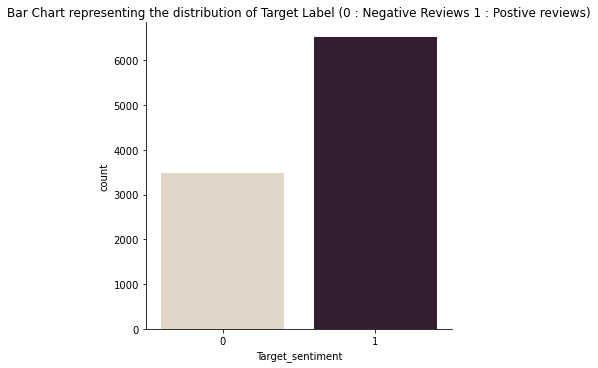

In [15]:
## Calling above function to plot the count plot of the reviews
plot_countplot(data_review_rest_2 )

- The above plot is the count plot of the reviews
- Number of negative reviews are almost half of the postive reviwes
- Number of negative reviews: 3200 and Number of positive reviews: 6800
- From the above plot we can also see that the data is slightly imbalance

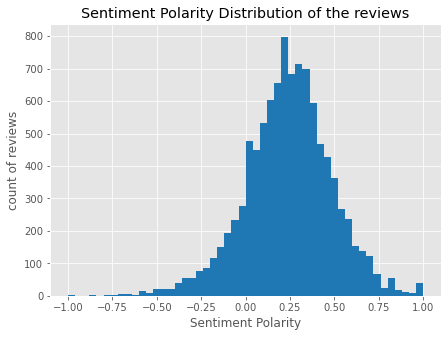

In [16]:
## Calling the above function to plot the histogram of the sentiment polarity of the reviews
plot_histogram(data_vi["sentiment_polarity"], x = "Sentiment Polarity", y = "count of reviews", t = 'Sentiment Polarity Distribution of the reviews')

- The above plot shows the histogram of the sentiment polarity of all the reviews
- Here we can see that there are good number  of positive sentiment reviews as well of the negative seniment reviwes

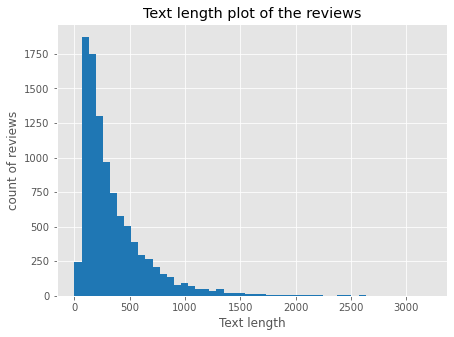

In [17]:
## Calling the above function to plot tbe text length of the reviews
plot_histogram(data_vi["text_length"], x = "Text length", y = "count of reviews", t = 'Text length plot of the reviews')


- The above plot shows the histogram of the text length of all the reviews
- We can see that the text length of the reivews mostly lies between 100 to 400

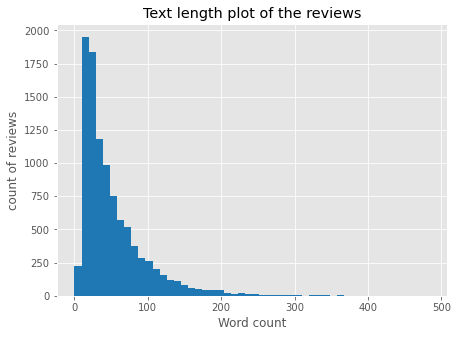

In [18]:
## Calling the above function for plotting the histogram of the word count
plot_histogram(data_vi["Word_count"], x = "Word count", y = "count of reviews", t = 'Text length plot of the reviews')


- The above plot shows the histogram of the word count of all the reviews
- Here we can see that the word count of the reviews lies between 40 to 90

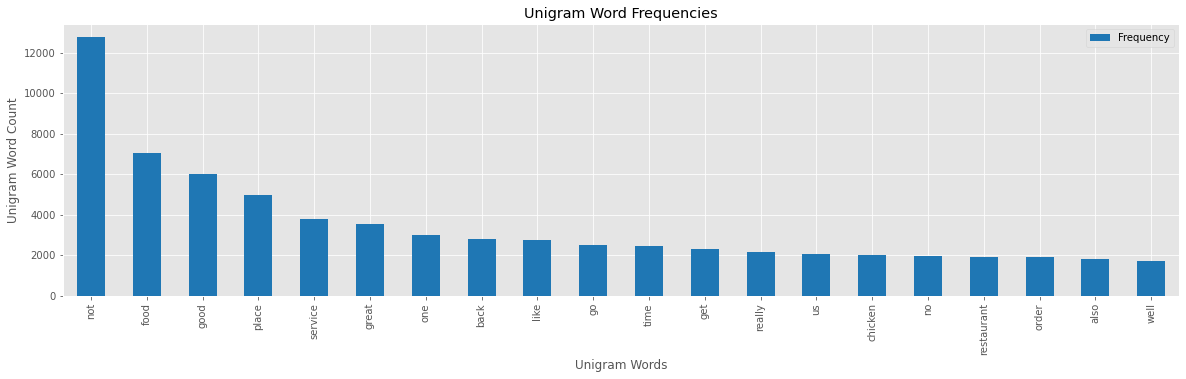

In [19]:
## Calling the above function to calculate the unigram word frequeicies of the reviews
word_df = plot_wordfrequencies(data_review_rest_2["text"])
## Calling the above function to plot the bar plot of top unigram words of reviews
plot_barchart(word_df,x = "Unigram Words", y = "Unigram Word Count", z = "Unigram Word Frequencies")


- The above plot shows the bar chart for the frequent unigram words in the reviews
- Here we can see that the top words used are "not", "food", "good", "place", which is obvious cause this indicates the postive and negative sentiment in the reviews

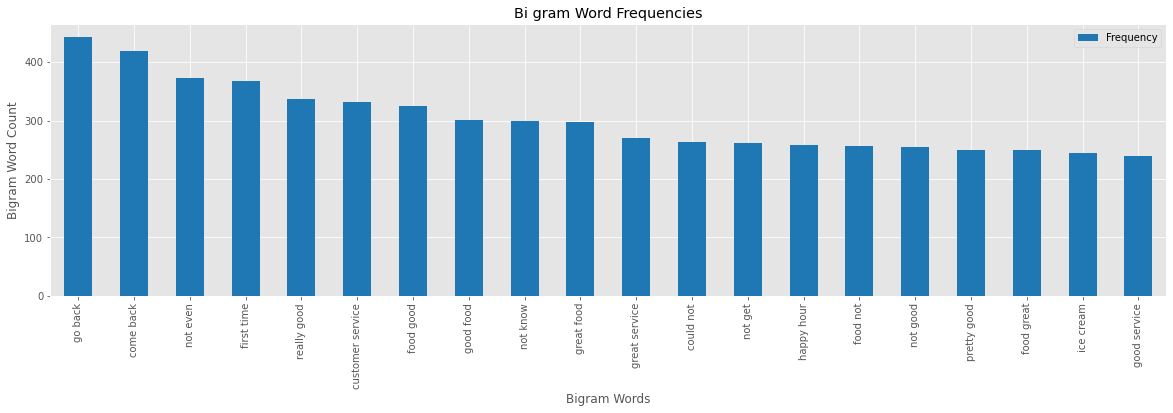

In [20]:
## Calling the above function to calculate the Bi-gram word frequeicies of the reviews
word_df1, vectors = bigram_wordfreqplot(data_review_rest_2["text"])
## Calling the above function to plot the bar plot of top bigram words of reviews
plot_barchart(word_df1,x = "Bigram Words", y = "Bigram Word Count", z = "Bi gram Word Frequencies")


- The above plot shows the bar chart for the frequent bigram words in the reviews
- Here we can see that the top words used are "go back", "come back", which is obvious cause this indicates the postive and negative sentiment in the reviews

In [22]:
## Code for standarizing the numerical features
scaler =StandardScaler()
scaler.fit(vectors) 
X = scaler.transform(vectors)

In [23]:
#### Clustering
## Function for choosing best k using elbow method
def elbow(X):
    inertia = {}
    for k in range (5):
        kmeanModel = KMeans(n_clusters= k + 1)
        kmeanModel.fit(X)
        inertia[k+1] =kmeanModel.inertia_
## Plotting the graph of inertia against the number of cluster
    plt.plot(*zip(*sorted(inertia.items())))
    plt.show()
    print(inertia)
    return(inertia)
        

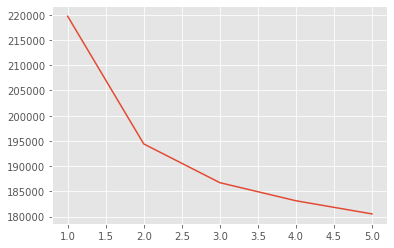

{1: 219732.3688000004, 2: 194399.85585833868, 3: 186711.52174607222, 4: 183124.6838321862, 5: 180514.03666494472}


In [24]:
## calling above function elbow
best_k = elbow(vectors)

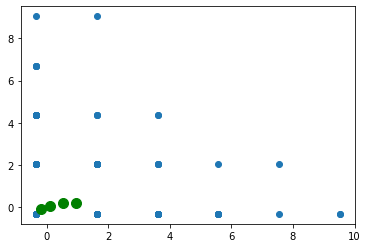

The v_measure and the cluster  1.4429643883295968


In [27]:
## Using the best k obtained using the elbow and external measuring method
kmeans = KMeans(n_clusters =  max(best_clus, key = best_clus.get), init='k-means++', max_iter= 10, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0],X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='green')
plt.show()
score_h_c_v = metrics.homogeneity_completeness_v_measure(data_review_rest_2["Target_sentiment"], pred_y)
print("The v_measure and the cluster ", score_h_c_v[2]*100)

#### 2. Bi-Variate Visualization

In [21]:
## This function is to calculate and plot bivaraite histograms
def plot_vi(data_visual,d,e,x,y,z,t):
    vis1 = data_visual.loc[data_vi['Target_sentiment'] == 1, z]
    vis2 = data_visual.loc[data_vi['Target_sentiment'] == 0, z]
    
    
    ## Plot histogram for distribution of the reviews
    fig, ax = plt.subplots(figsize=(10,5))
    plt.hist(vis1, bins=50, color = "tab:blue", label = d);
    plt.hist(vis2, bins=50, color = "tab:cyan", label = e);
    plt.legend(loc='upper right')
    ax.set_title(t)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

In [22]:
## This function is to calculate and plot bivaraite barcharts
def plot_words_unigram_and_bigram(index1,index2,freq1,freq2,t,a,b):
    f, ax= plt.subplots(2,2,figsize=(15,5))
    ax = plt.subplot(111)
    
    ## Plot bi variate barcharts for the reviews 
    ax.bar(index1,freq1, width=0.5, color='tab:blue', align='center', label = "Words in postive reviews ")
    ax.bar(index2,freq2, width=0.5, color='tab:cyan', align='center', label = "words in negative reviews")
    plt.xticks(rotation=90)
    plt.xlabel(a)
    plt.ylabel(b)
    plt.title(t)
    plt.legend()

    plt.show()

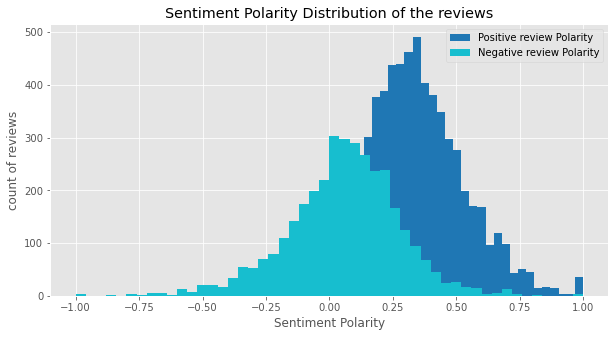

In [23]:
## Calling the above function to plot the histogram of the sentiment polarity for both postive and negative reviews
plot_vi(data_vi,d = "Positive review Polarity", e = "Negative review Polarity",x = "Sentiment Polarity", y = "count of reviews", t = "Sentiment Polarity Distribution of the reviews",z="sentiment_polarity")

- The above plot shows the histogram of the sentiment polarity of both positive and negative reviews
- Here we can see that good number of negative reviews have negative polarity and good number of postive reviews have positive polarity

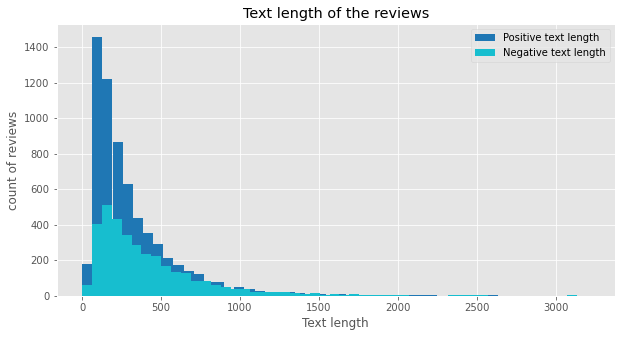

In [24]:
## Calling the above function to plot tbe text length for both postive and negative reviews
plot_vi(data_vi,d = "Positive text length", e = "Negative text length",x = "Text length", y = "count of reviews", t = "Text length of the reviews",z="text_length")


- The above plot shows the histogram of the text length for both positive and negative reviews
- We can see that the text length of the negative reviews are between 100 to 400 mostly which is same for the postive reviews its same too

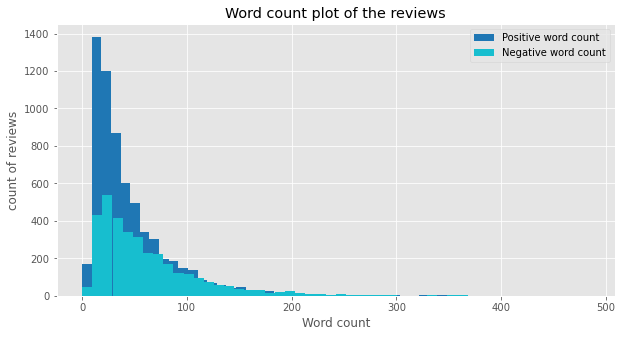

In [25]:
## Calling the above function to plot tbe word count for both postive and negative reviews
plot_vi(data_vi,d = "Positive word count", e = "Negative word count",x = "Word count", y = "count of reviews", t = "Word count plot of the reviews",z= "Word_count")


- The above plot shows the histogram of the word count for both positive and negative reviews
- Here we can see that the word count of the negative reviews lies between 40 to 90 and it is also the same for the postive reviews

In [26]:
## Separting the postive and negative reviews and getting the unigram words and their frequencies
word_vis1 = plot_wordfrequencies(data_vi.loc[data_vi['Target_sentiment'] == 1, "text"])
word_vis2 = plot_wordfrequencies(data_vi.loc[data_vi['Target_sentiment'] == 0, "text"])

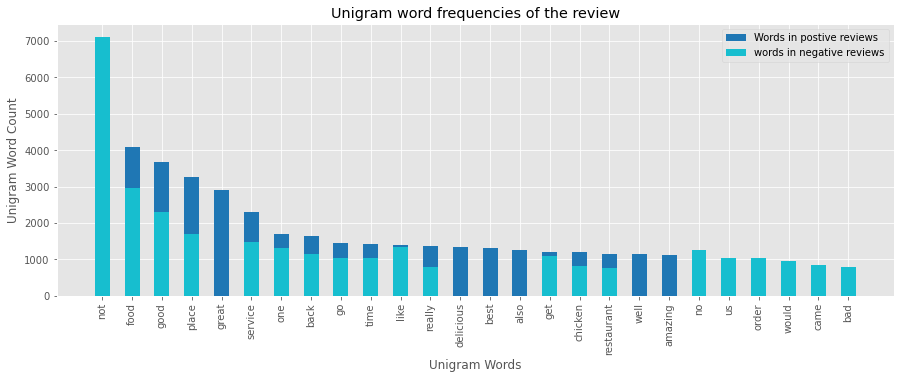

In [27]:
## Calling the above function to plot the bar chart of unigram words for both positive and negative reviews
plot_words_unigram_and_bigram(word_vis1.index,word_vis2.index,word_vis1["Frequency"],word_vis2["Frequency"], t = "Unigram word frequencies of the review", a = "Unigram Words", b = "Unigram Word Count")



- The above plot shows the bar chart for the frequent unigram words in both postive and negative reviews
- Here we can see that the top words used are "not", "food", "good", "place", which is obvious cause this indicates the postive and negative sentiment in the reviews
- As we can see that word "not" is mostly used in negative reviews
- And the word "great" is mostly used in positive reviews
- This give us impression that if we can create good features than we will able to separate positive and negative reviews

In [28]:
## Separting the postive and negative reviews and getting the bigram words and their frequencies
word_vis4 = bigram_wordfreqplot(data_vi.loc[data_vi['Target_sentiment'] == 1, "text"])
word_vis5 = bigram_wordfreqplot(data_vi.loc[data_vi['Target_sentiment'] == 0, "text"])

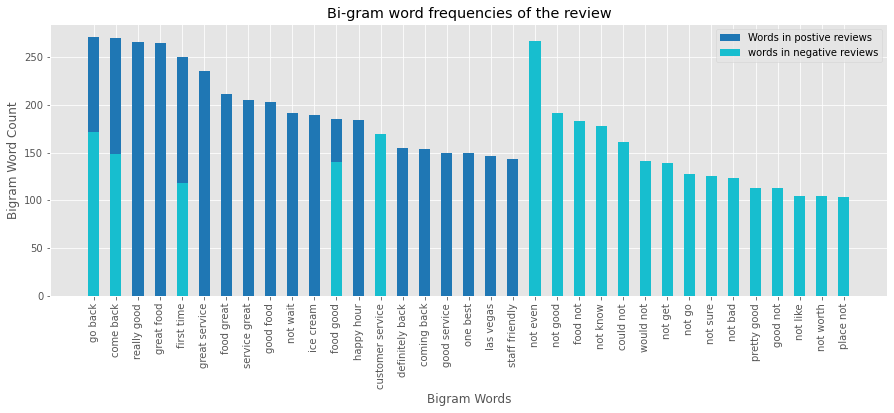

In [29]:
## Calling the above function to plot the bar chart of biigram words for both positive and negative reviews
plot_words_unigram_and_bigram(word_vis4.index,word_vis5.index,word_vis4["Frequency"],word_vis5["Frequency"], t = "Bi-gram word frequencies of the review",a = "Bigram Words", b = "Bigram Word Count")

- The above plot shows the bar chart for the frequent bigram words in both postive and negative reviews
- Here we can see that the top words used are "go back", "come back" which is obvious cause this indicates the postive and negative sentiment in the reviews
- As we can see that word "not good" is mostly used in negative reviews
- And the word "really great" is mostly used in positive reviews
- This give us impression that if we can create good bigram weightage features than we will able to separate positive and negative reviews

#### 3. Correlation Matrix

In [30]:
def matrix(data_vi):
    matrix_corr = data_vi.corr()
    sns.heatmap(matrix_corr, annot=True)
    plt.show()

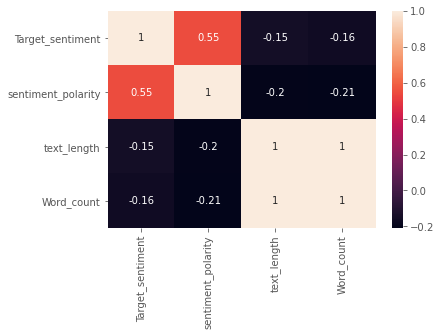

In [31]:
matrix(data_vi)

- The above graph shows the correlation between the numerical features
- Word count and text length are highly correlated
- Therefore, we will drop word count and use text length
- The features which will be used are "text (Reviews)" and "text_length"

## Model Building

#### Splitting the dataset

In [32]:
## This code is for spliting the data for train, dev and test set
X_train, X_test, y_train, y_test = train_test_split(data_vi.drop(columns = ["Target_sentiment","sentiment_polarity","Word_count"], axis = 1), data_review_rest_2["Target_sentiment"],
                                                   test_size = 0.2, random_state = 40, stratify = data_review_rest_2["Target_sentiment"] )

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train,
                                                   test_size = 0.2, random_state = 40, stratify = y_train)

In [33]:
print("Shape of the train set:", X_train.shape, y_train.shape)
print("Shape of the dev set:", X_dev.shape, y_dev.shape)
print("shape of the test set:", X_test.shape, y_test.shape )


Shape of the train set: (6400, 2) (6400,)
Shape of the dev set: (1600, 2) (1600,)
shape of the test set: (2000, 2) (2000,)


#### Feature Engineering/Selection


#### 1. Term Frequency - Inverse document frequency feature

In [54]:
## Function for creating tf-idf vectors from text

def tfidf_vec(train,dev,test):
    vectorizer = TfidfVectorizer(ngram_range=(2,2),max_features = 3000)
    vectorizer.fit(train['text'].values)
    
    X_train_reviews_tfidf = vectorizer.transform(train['text'].values)
    X_dev_reviews_tfidf = vectorizer.transform(dev['text'].values)
    X_test_reviews_tfidf = vectorizer.transform(test['text'].values)
    
    print("After vectorizations")
    print(X_train_reviews_tfidf.shape)
    print(X_dev_reviews_tfidf.shape)
    print(X_test_reviews_tfidf.shape)
    print("="*100)
    return(X_train_reviews_tfidf,X_dev_reviews_tfidf,X_test_reviews_tfidf )

#### 2. Spacy feature

In [70]:
## Function for converting text in to spacy vectors
def spacy_text(data):
    """
    Returns a dataframe representation of spacy Vectors
    """
## Loading the Spacy Vectors
    nlp = spacy.load('en_core_web_lg')
    spacy_vec = []
    for text in tqdm(data["text"]):
        vec = np.zeros(300)
        word_count = 0
        for word in text.split():
## Converting each word in to vectors
            token = nlp(word)
## Adding the  word vectors of each sentence
            vec = vec + token.vector
            word_count = word_count + 1
        if word_count != 0:
            f = []
            for i in vec:
## Taking the average of the vectors based on the word count
                f.append(i/word_count)
        spacy_vec.append(f)
    X = pd.DataFrame(columns = ['q1'])
    X['q1'] = list(spacy_vec)
    df1 = pd.DataFrame(X.q1.values.tolist(), index= X.index)
    return(spacy_vec,df1)

#### 3. Numerical Feature

In [55]:
## Function for performing standarization on the numerical feature

def standarizing_numerical(train,dev,test):
    normaliser = Normalizer()
    normaliser.fit(train['text_length'].values.reshape(-1,1))
    
    
    X_train_text_len_stand = normaliser.transform(train['text_length'].values.reshape(-1,1))
    X_dev_text_len_stand = normaliser.transform(dev['text_length'].values.reshape(-1,1))
    X_test_text_len_stand = normaliser.transform(test['text_length'].values.reshape(-1,1))
    print("After Normalization")
    print(X_train_text_len_stand.shape)
    print(X_dev_text_len_stand.shape)
    print(X_test_text_len_stand.shape)
    print("="*100)
    
    return(X_train_text_len_stand,X_dev_text_len_stand, X_test_text_len_stand)

In [56]:
## Calling the above tfidf_vec function to create 3000 dimensional bigram feature
X_train_reviews_tfidf,X_dev_text_len_stand_tfidf,X_test_reviews_tfidf = tfidf_vec(X_train,X_dev,X_test)

After vectorizations
(6400, 3000)
(1600, 3000)
(2000, 3000)


In [71]:
## Calling the above function spacy_text to create spacy vector feature
X_train_reviews_spacy, X_df_train_reviews_spacy = spacy_text(X_train)
X_dev_reviews_spacy, X_df_dev_reviews_spacy = spacy_text(X_dev)
X_test_reviews_spacy, X_df_test_reviews_spacy = spacy_text(X_test)


100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


In [39]:
X_df_train_reviews_spacy.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.216094,0.142791,0.135229,-0.128427,0.167149,0.177011,0.059671,-0.095726,0.179435,1.533605,...,-0.079028,0.041549,-0.195692,-0.077286,-0.121196,-0.052510,0.017642,-0.445748,0.107129,0.019843
1,-0.086602,0.065982,0.017619,-0.017231,0.176523,0.016388,-0.031095,-0.117049,0.052961,2.235406,...,0.042852,0.103844,0.038896,0.033310,0.131209,-0.001597,-0.053390,-0.093712,0.065118,0.115075


In [40]:
X_df_dev_reviews_spacy.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.077711,0.179661,-0.097349,-0.170171,0.085038,-0.084955,-0.016761,-0.269290,0.075518,2.216465,...,-0.187256,0.069951,-0.019146,-0.070383,0.055666,0.069474,-0.003705,-0.101231,0.110459,0.144021
1,-0.056053,0.140535,0.032746,0.057659,-0.025662,-0.010227,0.061703,-0.100315,0.014031,2.091592,...,-0.110747,0.168387,0.009615,-0.004225,0.021943,0.046601,0.027322,-0.177897,-0.010159,0.042371


In [41]:
X_df_test_reviews_spacy.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.023975,0.095727,-0.062872,-0.134788,0.014780,-0.044634,-0.021549,-0.132796,0.074216,1.410690,...,0.008040,0.027118,-0.006011,-0.098454,0.054855,0.028420,-0.029876,-0.162966,0.078490,0.072040
1,-0.042406,0.088984,-0.098529,-0.032884,0.117176,0.114682,0.055541,-0.169726,0.107750,1.634476,...,-0.115465,0.065083,-0.061084,-0.008445,0.020765,-0.087688,0.016250,-0.247793,0.022508,0.135205


In [57]:
## calling the above function to normalise the numerical feature text length
X_train_text_len_stand,X_dev_text_len_stand, X_test_text_len_stand = standarizing_numerical(X_train,X_dev,X_test)

After Normalization
(6400, 1)
(1600, 1)
(2000, 1)


In [58]:
## Fuction for merging textual vectors and numerical feature
def merging(train1,train2,dev1,dev2,test1,test2,tx):
    train_datam = hstack((train1,train2)).tocsr()
    dev_datam = hstack((dev1,dev2)).tocsr()
    test_datam = hstack((test1,test2 )).tocsr()
    
    
    print(tx +"final data matrix developed")
    print(train_datam.shape)
    print(dev_datam.shape)
    print(test_datam.shape)
    print("="*100)
    
    return(train_datam,dev_datam,test_datam)

In [59]:
###### Calling the above function to merge tfidf vectors and numerical text length feature
train_data_tfidf, dev_data_tfidf, test_data_tfidf = merging(X_train_reviews_tfidf,X_train_text_len_stand,X_dev_text_len_stand_tfidf,X_dev_text_len_stand,X_test_reviews_tfidf, X_test_text_len_stand,tx = "TFIDF ",)

TFIDF final data matrix developed
(6400, 3001)
(1600, 3001)
(2000, 3001)


In [72]:
####### Calling the above function to merge spacy vectors and numerical text length feature
train_data_spacy, dev_data_spacy, test_data_spacy = merging(X_df_train_reviews_spacy,X_train_text_len_stand,X_df_dev_reviews_spacy,X_dev_text_len_stand,X_df_test_reviews_spacy, X_test_text_len_stand, tx = "Spacy ")

Spacy final data matrix developed
(6400, 301)
(1600, 301)
(2000, 301)


In [73]:
#### Function for evaluating models

def evaluate(y_test,y_pred):
    cf_matrix = confusion_matrix(y_test,y_test_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    print("Precision Score of the model:", precision_score(y_test,y_pred)*100)
    print("Recall Score of the model:", recall_score(y_test,y_pred)*100)
    print("Acuracy score of the model:",accuracy_score(y_test,y_pred)*100)
    print("F1 score of the model:",f1_score(y_test,y_pred)*100)
    
    
        

#### Baseline Models with features TFIDF and Reviews Length

#### 1. Multinomial Naive Bayes with default parameter-> Baseline

In [41]:
## Initilizaing multinomial naive bayes model and fitting the train data
model =  MultinomialNB()
model = model.fit(train_data_tfidf, y_train)


Precision Score of the model: 65.7243816254417
Recall Score of the model: 99.77011494252874
Acuracy score of the model: 65.9
F1 score of the model: 79.24528301886792


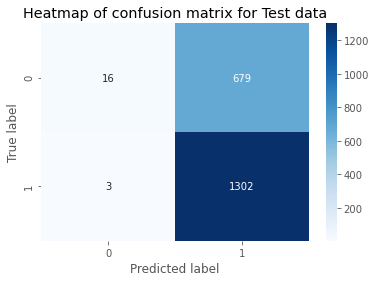

In [42]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_tfidf)
evaluate(y_test,y_test_pred )

- The above model used is a Baseline model -> multinomial Naive bayes with default parameters
- As we can see that precision score is quite low
- But the recall score is very high
- And the accuracy is low again
- This is mostly because of the that the model is able to predict on the postive reviews correctly but not predicting correctly for the negative reviews
- This is mostly beacause of the imbalance of the classes

#### 2.  Decision Tree with default parameter-> Baseline

In [43]:
## Initilizaing decision tree classifier and fitting the train data
model = DecisionTreeClassifier()
model = model.fit(train_data_tfidf,y_train)

Precision Score of the model: 65.80416032470828
Recall Score of the model: 99.38697318007664
Acuracy score of the model: 65.9
F1 score of the model: 79.18192918192919


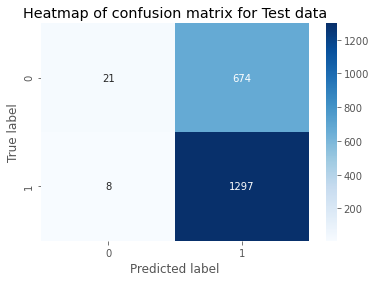

In [44]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_tfidf)
evaluate(y_test,y_test_pred )

- The above model used is a Decision tree classifier with default parameters
- As we can see that precision score is quite low
- But the recall score is very high
- And again the accuracy is low again
- This is mostly because of the that the model is able to predict on the postive reviews correctly but not predicting correctly for the negative reviews
- This is mostly beacause of the imbalance of the classes

#### 3. Support Vector Machine with default parameter -> Baseline

In [45]:
## Initilizaing support vector classifier and fitting the train data
model = svm.SVC()
model = model.fit(train_data_tfidf,y_train)

Precision Score of the model: 65.77350859453995
Recall Score of the model: 99.69348659003832
Acuracy score of the model: 65.95
F1 score of the model: 79.2567773378008


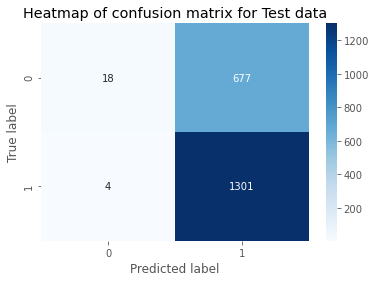

In [46]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_tfidf)
evaluate(y_test,y_test_pred )

- The above model used is a Support Vector classifier with default parameters
- As we can see that precision score is quite low
- But the recall score is very high
- And again the accuracy is low again
- This is mostly because of the that the model is able to predict on the postive reviews correctly but not predicting correctly for the negative reviews
- This is mostly beacause of the imbalance of the classes

#### 4. Random Forest with default parameters -> Baseline

In [47]:
## Initilizaing random forest classifier and fitting the train data
clf =  RandomForestClassifier()
clf = clf.fit(train_data_tfidf, y_train)


Precision Score of the model: 65.78947368421053
Recall Score of the model: 99.61685823754789
Acuracy score of the model: 65.95
F1 score of the model: 79.24413288631514


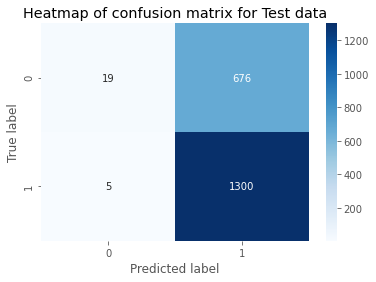

In [48]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = clf.predict(test_data_tfidf)
evaluate(y_test,y_test_pred )

- The above model used is a Random forest classifier with default parameters
- As we can see that precision score is quite low
- But the recall score is very high
- And again the accuracy is low again
- This is mostly because of the that the model is able to predict on the postive reviews correctly but not predicting correctly for the negative reviews
- This is mostly beacause of the imbalance of the classes

#### Oversampling Models with features TFIDF and Reviews Length and hyperparametuning of Algorithms

- Since our baseline model performed badly on the data we will do oversampling of the traingin set and perform hyperparametuning of algorithms to get good results

##### OverSampling using RandomOver sampler of Imblearn library

In [61]:
## function for oversampling the train dataset
def oversampling(train_s,y_trains):
    ros = RandomOverSampler(random_state=0)
    train_data1, y_train1 = ros.fit_resample(train_s, y_trains)
    return(train_data1, y_train1)
    

In [62]:
## Calling the above function to oversample the train dataset with tfidf and text length feature
train_data1_tfidf,y_train1_tfidf = oversampling(train_data_tfidf,y_train)

##### GridSearch Hyperparameter Tuning

In [63]:
## Function for hypetuning the parameters for the algorithm by using gridsearch cross validation
def hyper_tuning(t_d,y_t,alpha,parameters):
    clf = GridSearchCV(alpha, param_grid= parameters, cv=5, scoring='f1',return_train_score= True)
    hyper = clf.fit(t_d,y_t)
    print("Best parameters for the algorithm", hyper.best_estimator_)
    print("Best cross validation score :", hyper.best_score_)
    return(hyper.best_estimator_)

#### 1. Multinomial naive bayes with oversampling of the train dataset and hyperparameter tuning and with TFIDF

In [52]:
## Calling the above function for tuning multinomial naive bayes algorithm using gridsearch cv then fitting the train dataset with best parameter
model =  hyper_tuning(train_data1_tfidf,y_train1_tfidf,alpha = MultinomialNB(fit_prior=True, class_prior=None),parameters = {'alpha':[1000,500,100,50,10,5,0.5,1, 0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]})
model = model.fit(train_data1_tfidf, y_train1_tfidf)


Best parameters for the algorithm MultinomialNB(alpha=500)
Best cross validation score : 0.5961965517914376


Precision Score of the model: 65.73745565129245
Recall Score of the model: 99.38697318007664
Acuracy score of the model: 65.8
F1 score of the model: 79.13361805979255


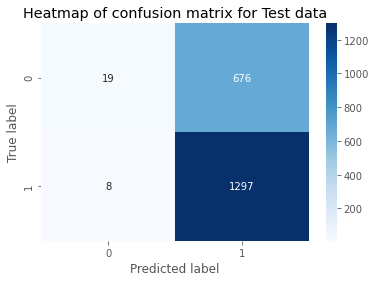

In [53]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_tfidf)
evaluate(y_test,y_test_pred)

#### 2. Decision Tress with oversampling of the train dataset and hyperparameter tuning and with TFIDF

In [64]:
## Calling the above function for tuning decision tree classifier using gridsearch cv then fitting the train dataset with best parameter
model =  hyper_tuning(train_data1_tfidf,y_train1_tfidf,alpha = DecisionTreeClassifier(),parameters = {"max_features":[1,2,3,4,5],"max_depth":[int(x) for x in range(10)],"min_samples_leaf":[1,2,3,4,5],"min_samples_split":[1,2,3,4,5],"criterion":["gini","entropy"]})
model = model.fit(train_data1_tfidf, y_train1_tfidf)

Best parameters for the algorithm DecisionTreeClassifier(max_depth=9, max_features=5, min_samples_leaf=4,
                       min_samples_split=5)
Best cross validation score : 0.6742219891120836


Precision Score of the model: 66.26756897449245
Recall Score of the model: 97.54789272030652
Acuracy score of the model: 66.0
F1 score of the model: 78.92126472411655


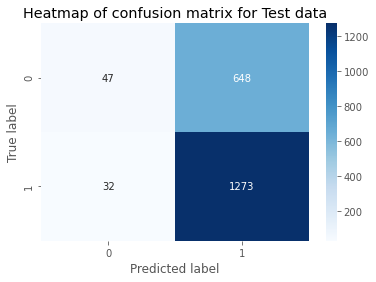

In [65]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_tfidf)
evaluate(y_test,y_test_pred)

- The above model used is a Decision tree classifier classifier with oversampled train dataset and hypertuned parameter
- Again with oversampled train dataset precision score did not improve for this algorithm
- Same with the recall score
- Same with the accuracy score
- This is mostly because of the that the model is able to predict on the postive reviews correctly but not predicting correctly for the negative reviews

#### 3. Support Vector Machine with oversampling of the train dataset and hyperparameter tuning and with tfidf

In [66]:
## Calling the above function for tuning Support vector classifier algorithm using gridsearch cv then fitting the train dataset with best parameter
model = hyper_tuning(train_data1_tfidf,y_train1_tfidf,alpha =  SGDClassifier(loss = 'hinge'),parameters = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty' :[ 'l2','l1'],'max_iter':[20]})
model = model.fit(train_data1_tfidf, y_train1_tfidf)

Best parameters for the algorithm SGDClassifier(max_iter=20)
Best cross validation score : 0.8506114449202592


Precision Score of the model: 85.18815052041633
Recall Score of the model: 81.53256704980842
Acuracy score of the model: 78.7
F1 score of the model: 83.32028191072827


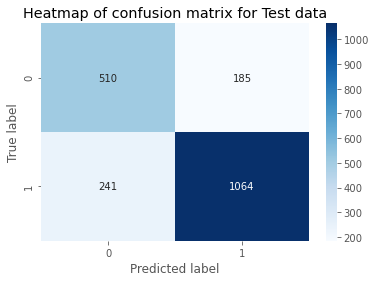

In [67]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_tfidf)
evaluate(y_test,y_test_pred)

- The above model used is a Support vector classifier classifier with oversampled train dataset and hypertuned parameter
-  with oversampled train dataset precision score improve a lot
-  Even the recall score is good
- Accuracy has also improved a lot
- This is better model than above models


#### 4. Random Forest with oversampling of the train dataset and hyperparameter tuning and with Tfidf

In [68]:
## Calling the above function for tuning Random Forest classifier algorithm using gridsearch cv then fitting the train dataset with best parameter
model = hyper_tuning(train_data1_tfidf,y_train1_tfidf,alpha =  RandomForestClassifier(n_jobs = -1),parameters = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],'max_depth':[int(x) for x in np.linspace(10, 110, num = 11)],'min_samples_split':[2, 5, 10],'min_samples_leaf':[1, 2, 4]})
model = model.fit(train_data1_tfidf, y_train1_tfidf)

Best parameters for the algorithm RandomForestClassifier(max_depth=100, min_samples_leaf=5, n_jobs=-1)
Best cross validation score : 0.7892232577241514


Precision Score of the model: 81.1029411764706
Recall Score of the model: 84.52107279693487
Acuracy score of the model: 77.05
F1 score of the model: 82.7767354596623


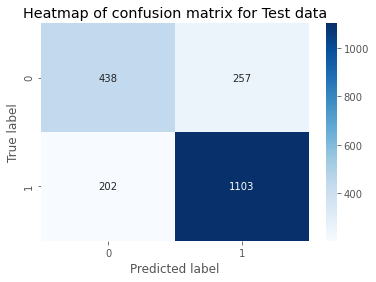

In [69]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_tfidf)
evaluate(y_test,y_test_pred)

- The above model used is a Random forest classifier classifier with oversampled train dataset and hypertuned parameter
-  with oversampled train dataset precision score improve a lot
-  Even the recall score is good
- Accuracy has also improved a lot
- considering the baseline model F1 score is good
- This is better model than above models


#### Oversampling Models with features Spacy and Reviews Length and hyperparametuning of Algorithms

In [74]:
## Calling the above function to oversample the train dataset with Spacy and text length feature
train_data1_spacy,y_train1_spacy = oversampling(train_data_spacy ,y_train)

####  1. Support Vector Machine with oversampling of the train dataset and hyperparameter tuning (Spacy and text length feature)

In [75]:
## Calling the above function for tuning Support vector classifier algorithm using gridsearch cv then fitting the train dataset with best parameter
model = hyper_tuning(train_data1_spacy,y_train1_spacy,alpha =  SGDClassifier(loss = 'hinge'),parameters = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty' :[ 'l2','l1'],'max_iter':[20]})
model = model.fit(train_data1_spacy, y_train1_spacy)

Best parameters for the algorithm SGDClassifier(alpha=0.0005, max_iter=20)
Best cross validation score : 0.8499719823618053


Precision Score of the model: 88.35666912306559
Recall Score of the model: 91.87739463601532
Acuracy score of the model: 86.8
F1 score of the model: 90.08264462809919


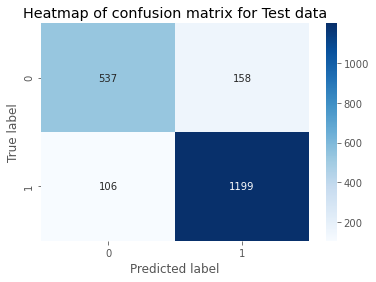

In [76]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_spacy)
evaluate(y_test,y_test_pred)

- The above model used is a Support vector classifier classifier with oversampled train dataset and hypertuned parameter for spacy and text length feature
- with oversampled train dataset precision score is best for the test dataset for this algorithm
- Even the recall score is excellent
- Accuracy has also improved a lot
- This is better model than above models
- F1 score is better best among all the models 90.08

#### 2. Random Forest with oversampling of the train dataset and hyperparameter tuning (Spacy and text length feature)

In [77]:
## Calling the above function for tuning Random forest classifier algorithm using gridsearch cv then fitting the train dataset with best parameter
model = hyper_tuning(train_data1_spacy,y_train1_spacy,alpha =  RandomForestClassifier(n_jobs = -1),parameters = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],'max_depth':[int(x) for x in np.linspace(10, 110, num = 11)],'min_samples_split':[2,4, 5, 10],'min_samples_leaf':[1, 2, 4]})
model = model.fit(train_data1_spacy, y_train1_spacy)

Best parameters for the algorithm RandomForestClassifier(max_depth=100, min_samples_leaf=4, min_samples_split=4,
                       n_jobs=-1)
Best cross validation score : 0.9041449520828116


Precision Score of the model: 85.621387283237
Recall Score of the model: 90.80459770114942
Acuracy score of the model: 84.05
F1 score of the model: 88.1368538490145


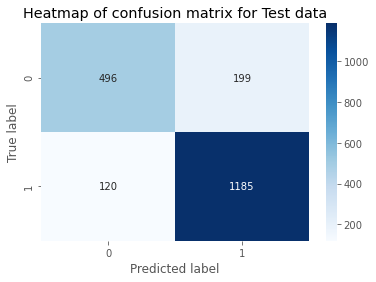

In [78]:
## prediction on the test dataset and then evalauting the model performance
y_test_pred = model.predict(test_data_spacy)
evaluate(y_test,y_test_pred)

- The above model used is a Random forest classifier with oversampled train dataset and hypertuned parameter for spacy and text length feature
- with oversampled train dataset precision score is best for the test dataset for this algorithm
- Even the recall score is excellent
- Accuracy has also improved a lot
- F1 is high too
